In [107]:
from utils.functions import *

import matplotlib.pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator

import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv('../data/clini_data.csv')

## I Présentation des données

Notre dataframe possède plus de 300 variables. On ne les utiliseras pas toutes, on présente alors les principales variables qu'on utilisera.

In [108]:
afficher_colonnes_manquantes(data, seuil=0.999)

╒════════════════════════════════════╤════════════════════════════════╤═════════════════════════════════════╕
│ Colonne                            │   Nombre de valeurs manquantes │   Pourcentage de valeurs manquantes │
╞════════════════════════════════════╪════════════════════════════════╪═════════════════════════════════════╡
│ BaselineMeasureDenomCountGroupId   │                         449894 │                             99.9764 │
├────────────────────────────────────┼────────────────────────────────┼─────────────────────────────────────┤
│ BaselineMeasureDenomCountValue     │                         449898 │                             99.9773 │
├────────────────────────────────────┼────────────────────────────────┼─────────────────────────────────────┤
│ BaselineMeasureDenomUnits          │                         449894 │                             99.9764 │
├────────────────────────────────────┼────────────────────────────────┼─────────────────────────────────────┤
│ Baseline

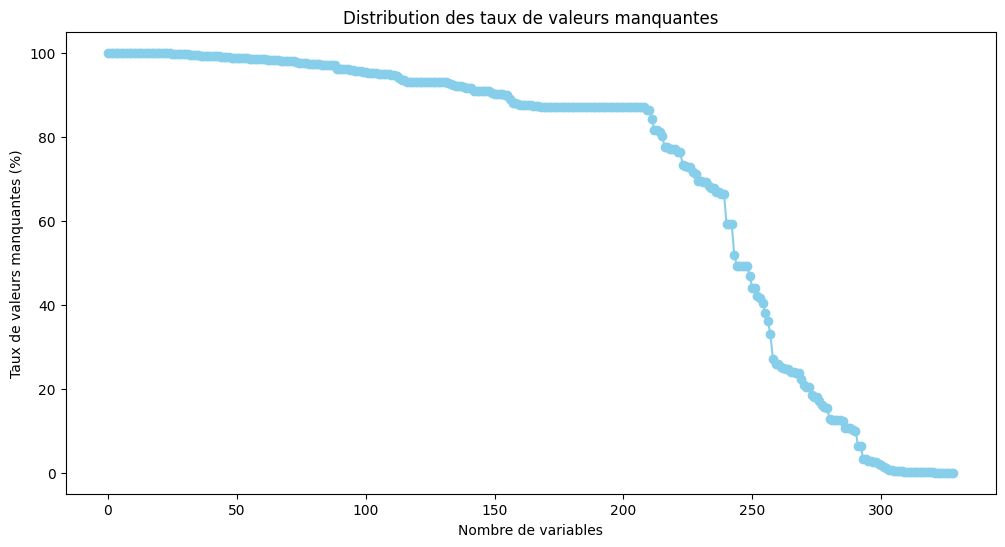

In [109]:
plot_distribution_valeurs_manquantes(data)

Environ la moitié des variables possèdent plus de ``99%`` de valeurs manquantes.

In [110]:
data.sample(10)[['NCTId','BriefTitle','StartDate', 'LocationCountry', 'StudyType', 'Phase','EligibilityCriteria',"LeadSponsorClass"]]

,NCTId,BriefTitle,StartDate,LocationCountry,StudyType,Phase,EligibilityCriteria,LeadSponsorClass
336108,NCT01803165,Lower Extremity Regional Anesthesia and Infrai...,May 2013,NaN,Observational,NaN,Inclusion Criteria:\n\nPatients 19 years of ag...,OTHER
429084,NCT00579475,The Effect of Mifepristone on Uterine Fibroids...,November 2004,Sweden,Interventional,Phase 1,Inclusion Criteria:\n\nUterine fibroids requir...,OTHER
336632,NCT01796301,An Open-label Study to Evaluate the Effect of ...,"January 31, 2013",United States,Interventional,Phase 3,"Inclusion Criteria:\n\nPostmenopausal women, a...",INDUSTRY
133785,NCT04442243,PTSD Symptoms Among Health Workers and Public ...,"June 22, 2020",NaN,Observational,NaN,Inclusion Criteria:\n\nHealth care or public s...,OTHER
38094,NCT05688137,Abdominal Drainage in the Postoperative Period...,"January 15, 2023",NaN,Interventional,Not Applicable,Inclusion Criteria:\n\nPatients of both sexes ...,OTHER
74445,NCT05215067,A Phase II Trial of AK104 in Advanced Non-Smal...,"March 9, 2022",China,Interventional,Phase 2,Inclusion Criteria:\n\n18 to 75 years old.\nHa...,INDUSTRY
6004,NCT06105645,Contribution of Fast-ripples to the Improvemen...,January 2024,France,Interventional,Not Applicable,Inclusion Criteria:\n\nPatient suffering from ...,OTHER
227355,NCT03223012,Impact of AbbVie Care Patient Support Program ...,"November 15, 2017",Portugal,Observational,NaN,Inclusion Criteria:\n\nDiagnosed with crohn's ...,INDUSTRY
62365,NCT05372302,Collecting Ducts Carcinoma: in Depth Explorati...,"July 8, 2021",Italy,Observational,NaN,Inclusion Criteria:\n\nAge ≥ 18 years\nSignatu...,OTHER
111377,NCT04734145,Using e-Nose Technology to Identify Early Lung...,"January 25, 2021",United States,Observational,NaN,"Inclusion Criteria:\n\nAge 21-85\nSingle, mono...",OTHER


#### NCTId

Le ``NCTId`` d'un essai clinique est l'identifiant NCT d'un essai clinique. Chaque essai clinique a un identifiant unique.

In [111]:
data['NCTId'].nunique() == len(data)

True

S'l y a eu un problème lors de la récolte des données, on peut supprimer les doublons à l'aide du NCTId.

#### Status de l'essai clinique

On s'intéresse au status de l'essai clinique, si celui ci est terminé, en cours de recrutement ou annulé. La variable ``OverallStatus`` nous indique le status de l'essais clinique. Cela nous permettra surtout de nous intéresser aux variables qui ont un impact sur le succès de l'essai clinique.

In [112]:
data['OverallStatus'].sample(7)

388904             Unknown status
157392                  Completed
45091     Enrolling by invitation
13484          Not yet recruiting
267412                  Withdrawn
102150                  Completed
147510                 Recruiting
Name: OverallStatus, dtype: object

#### Dates de l'essais cliniques

In [113]:
data['StartDateType'].unique()

array(['Anticipated', 'Actual', nan], dtype=object)

Etant donné qu'on cherche à expliquer la durée d'un essai clinique, on s'intéresse particulièrement aux variables précisant les dates de l'essai clinique. La variable ``StartDate`` indique la date de début de l'essai clinique. La variable ``StartDateType`` indique si la date précisée est factuelle ou prévue. Pour simplifier notre analyse, on traitera les dates de la même manière (si elles sont anticipées ou non).

In [114]:
data[['StartDate','StartDateType']].sample(10)

,StartDate,StartDateType
233170,"September 12, 2016",Actual
401261,July 2009,NaN
160192,"December 17, 2020",Actual
198831,"June 12, 2018",Actual
116916,"March 1, 2023",Actual
41265,"January 15, 2023",Actual
26261,"August 24, 2023",Actual
282980,April 2015,NaN
168002,"September 20, 2019",Actual
40306,January 2023,Anticipated


Les variables de dates sont sous forme de ``[str]`` et on doit donc les convertir en format datetime afin de pouvoir faire des opérations dessus. On appliquera cette transformation pour toute les variables relatives à la date qu'on utilisera.

In [115]:
type(data['StartDate'].iloc[20])

str

In [116]:
data['StartDate'] = pd.to_datetime(data['StartDate'], format='%B %d, %Y', errors='coerce')

In [117]:
type(data['StartDate'].iloc[20])

pandas._libs.tslibs.nattype.NaTType

La variable ``CompletionDate`` indique la date de fin (anticipée ou factuelle) d'un essai clinique. On différentie cette variable et ``StartDate`` pour avoir la durée d'un essai clinique et on crée la variable ``TimePassed``

In [118]:
df = data_treatment(data, max=3300)

In [119]:
df['TimePassed'].head(5)

0    1288.0
1    2556.0
2     638.0
3     365.0
4    1825.0
Name: TimePassed, dtype: float64

On applique une sélection de données. En effet certaines variables n'ont pas été renseignées correctement. Un certain nombre d'essai clinique on la même date pour ``StartDate`` et ``CompletionDate``. Or un essai clinique ne peut se réaliser en un seul jour, on suppose donc que cela est simplement du à une mauvaise compréhension de la variable lors de sa saisie. On ne prends pas en compte les essais cliniques ayant une durée trop élevé car ils relèvent généralement de cas particulier et peuvent être considérés comme des outliers.

#### Critères d'éligibilités

On utilise aussi les critères d'éligibilité car on veut voir si ils ont un impact sur la durée de vie d'un essai clinique. Les données présentent certains critères qui sont <u>standardisées</u> et d'autres non. Par exemple certains critères comme l'age et le sexe des patients demandées sont présents dans une variable précise comme ``MaximumAge`` tandis que d'autres critères, généralement plus complexes et divers sont présent dans la variable ``EligibilityCriteria`` sous forme de texte.

In [120]:
data[['MinimumAge','MaximumAge','Gender']].sample(10)

,MinimumAge,MaximumAge,Gender
220983,18 Years,NaN,All
394321,18 Years,NaN,All
398123,18 Years,60 Years,All
417412,18 Years,80 Years,All
81949,18 Years,80 Years,All
115987,18 Years,89 Years,All
371645,18 Years,NaN,All
41817,18 Years,65 Years,All
114756,18 Years,35 Years,All
154759,18 Years,100 Years,All


In [121]:
print(data['EligibilityCriteria'].iloc[10])

Inclusion criteria:

Adult subject (≥18 years old)
Patient operated on at the HUS between 01/02/2017 and 31/01/2019, for replacement of hip and knee prostheses
Patient having given their consent for the reuse of their data for the purposes of this research

Exclusion criteria:

- Patient who expressed their opposition to participating in the study


La variable ``EligibilityCriteria`` fera l'objet d'un traitement particulier. Afin de pouvoir comparer différents essais cliniques, on appliquera un modèle de NLP pour repérer les mots importants (par exemple les maladies, les procédures etc...) et ainsi obtenir le nombre de critères relatif à un domaine.

#### Variables Géographiques

On possède aussi le pays d'origine d'un essai clinique ainsi que le ou les pays où l'essai clinique cherche des patients.

In [122]:
data['LocationCountry'].value_counts().head(10)

LocationCountry
United States         151381
China                  31321
France                 24827
Canada                 15318
United Kingdom         12798
Germany                11945
Turkey                 10650
Korea, Republic of     10239
Italy                   9936
Egypt                   9822
Name: count, dtype: int64

On peut représenter sur une carte la répartition des essais cliniques.

In [123]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# On remplace les valeurs dans la colonne "LocationCountry" car les noms doivent correspondre à ceux de la bibliothèque géopandas
df['LocationCountry'] = df['LocationCountry'].replace('United States', 'United States of America')

merged_data = world.merge(df.groupby('LocationCountry').size().reset_index(name="Nombre d'essais cliniques"), left_on='name', right_on='LocationCountry', how='left').fillna(0)

fig = px.choropleth(merged_data, 
                    geojson=merged_data.geometry, 
                    locations=merged_data.index, 
                    color="Nombre d'essais cliniques",  # Utiliser le bon nom de colonne ici
                    hover_name='name',
                    color_continuous_scale='YlOrRd',
                    projection='natural earth')

fig.show()

In [124]:
# On peut refaire mais avec le logarithme du nombre d'essais cliniques car le nombre d'essais cliniques par pays est très dispersés
merged_data = world.merge(df.groupby('LocationCountry').size().reset_index(name="Nombre d'essais cliniques"), left_on='name', right_on='LocationCountry', how='left').fillna(0)

merged_data["Log_Nombre d'essais cliniques"] = np.log1p(merged_data["Nombre d'essais cliniques"])

fig = px.choropleth(merged_data, 
                    geojson=merged_data.geometry, 
                    locations=merged_data.index, 
                    color="Log_Nombre d'essais cliniques",  # Utiliser le bon nom de colonne ici
                    hover_name='name',
                    color_continuous_scale='YlOrRd',
                    projection='natural earth')

# Afficher la carte interactive
fig.show()

### Durée de vie d'un essai clinique, première analyse non paramétrique

On cherche ainsi à modéliser la durée de vie d'un essai clinique. Généralement dans le cadre de modèle de durée, on considère que des individus qui ont à chaque instant t une probabilité de sortir (inversement de survivre). Avant d'appliquer différents modèles pour estimer l'impact de certaines variables sur cette probabilité, il est commun de commencer par quelques estimations non paramétriques pour avoir une intuition des variables qui vont nous être importantes.

Formellement, soit X une variable aléatoire positive ou nulle qui représente la durée de vie d'un individu. On appelle la fonction de survie S telle que:

 $ S(t) = P( X > t), \quad t \geq 0 $

L'estimateur de Kaplan Meier estime cette fonction non paramétrique. La fonction de survie estimée par l'estimateur de Kaplan-Meier est donnée par :

$ \hat{S}(t) = \prod_{i: t_i \leq t} \frac{n_i - d_i}{n_i} $

Où :
- $ \hat{S}(t) $ est l'estimation de la fonction de survie à un temps donné $ t $.
- $ t_i $ sont les temps de survie observés.
- $ n_i $ est le nombre d'individus à risque au temps $ t_i $.
- $ d_i $ est le nombre d'événements de survie au temps $ t_i $, autrement dit, c'est le nombre d'individu qui sont sortis au temps i.



###### PS: Généralement dans les modèles de durée, on prends en compte la censure des données: on n'observe pas tout le temps si un individu est sorti, dans notre cas on n'observe pas si un essai clinique n'est pas encore terminée, il peut se terminer 3 jours après le rendu de notre projet ou 10 ans après. Ne pas prendre en compte la censure des données induit un biais dans les estimations. Etant donné qu'on possède les dates anticipées de début et de fin d'essai clinique, on ne traitera que les essais cliniques qui sont terminés ou une date de fin indiquée. Ce traitement peut induire un biais si le fait de ne pas préciser la date de fin prévu de l'essai clinique est corrélée à la durée de l'essai clinique. On fera l'hypothèse simplificatrice que ce n'est pas corrélé.

In [125]:
T = df['TimePassed']

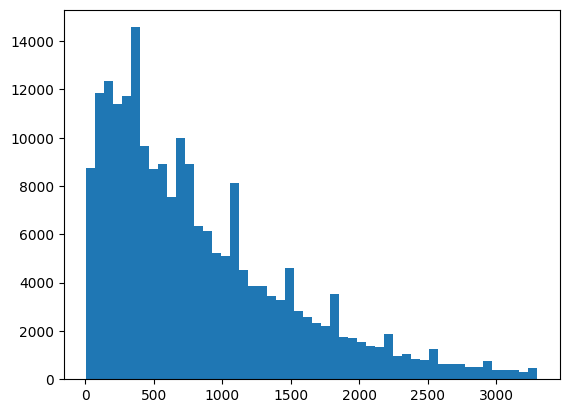

In [126]:
plt.hist(T, bins = 50)
plt.show()

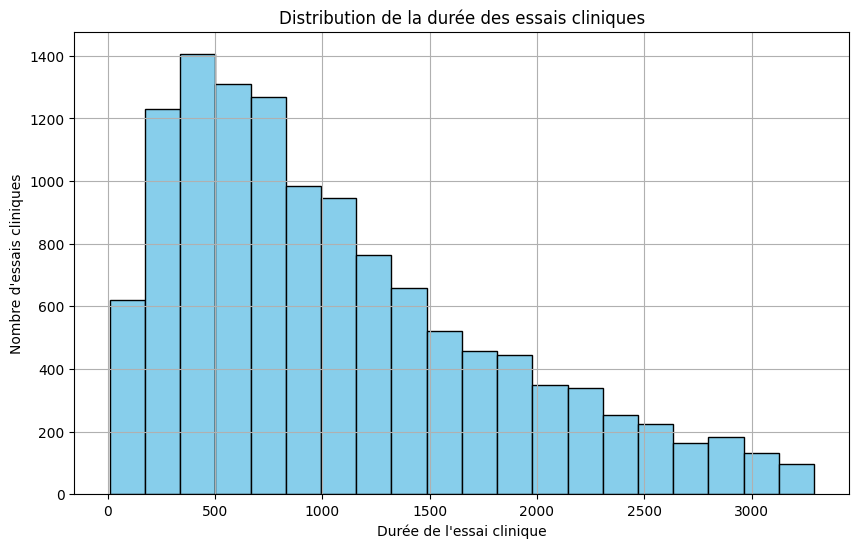

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df[df['Phase']=="Phase 3"]['TimePassed'], bins=20, color='skyblue', edgecolor='black')

plt.xlabel('Durée de l\'essai clinique')
plt.ylabel('Nombre d\'essais cliniques')
plt.title('Distribution de la durée des essais cliniques')

plt.grid(True)

plt.show()


L'estimateur de KaplanMeier est un estimateur non paramétrique de la fonction de survie. Il faut donc interpréter les résultats avec précautions. Ici: rien n'est égal par ailleur!

<Axes: xlabel='timeline'>

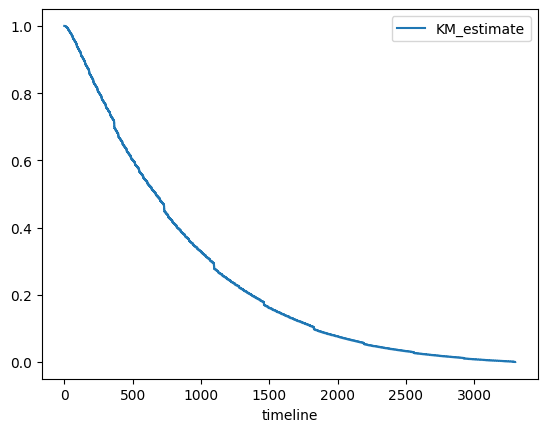

In [128]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T)
kmf.plot_survival_function()

In [129]:
df['event']= True

In [130]:
df['LocationCountry'].value_counts()[:10].index

Index(['United States of America', 'China', 'France', 'Turkey', 'Egypt',
       'United Kingdom', 'Canada', 'Italy', 'Spain', 'Korea, Republic of'],
      dtype='object', name='LocationCountry')

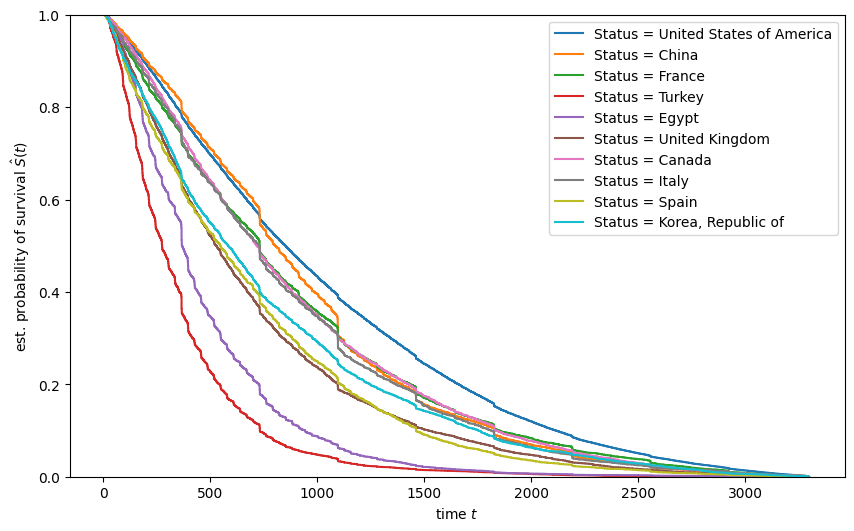

In [131]:
plot_survival_compar(df, 'LocationCountry')

Comment interpréter les courbes? Chaque courbe represente au point t la probabilité d'un individu de type j (ici le pays) de sortir à la date t. Ici on voit que certaines courbes sont au dessus d'autres sur tout le graphique, ce qui pourrait révéler que le fait de faire un essai clinique dans un pays influe la durée de l'essai clinique.

On regarde maintenant les sponsors, si le type du sponsor peut réveler des disparités.

In [132]:
df['LeadSponsorClass'].value_counts()

LeadSponsorClass
OTHER        153594
INDUSTRY      47281
OTHER_GOV      5326
NIH            2908
FED            1777
NETWORK        1285
INDIV           109
UNKNOWN          57
Name: count, dtype: int64

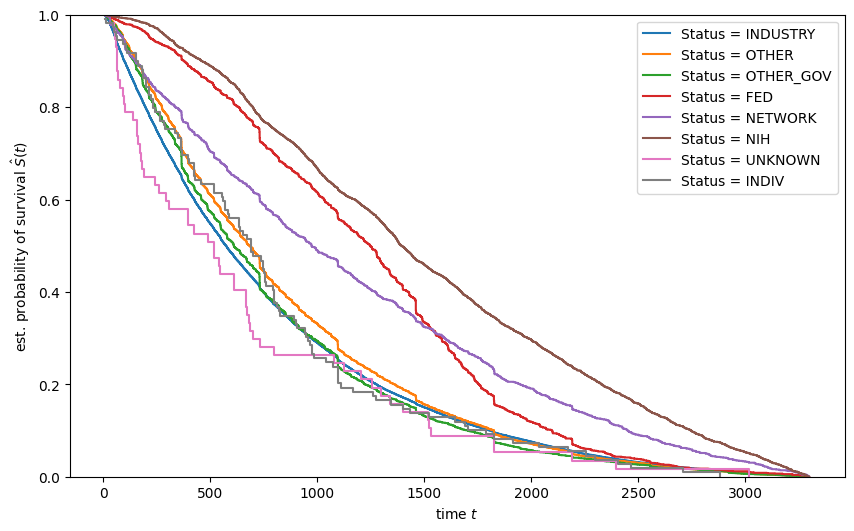

In [133]:
plot_survival_compar(df, 'LeadSponsorClass')

Certaines courbes ne sont pas très lisses car on dispose de peu de données. On remarque cependant qu'encore une fois, il y a une dominance de certaines courbes sur d'autres. On vérifiera nos résultats lors de l'estimation paramétrique.

Maintenant, est ce que le fait d'accepter des patients en bon état de santé pour l'essai clinique a un impact sur la durée de celui ci?

In [134]:
df['HealthyVolunteers'].fillna('').value_counts()

HealthyVolunteers
No                            142827
Accepts Healthy Volunteers     62117
                                7393
Name: count, dtype: int64

In [135]:
type(df['HealthyVolunteers'].iloc[0])

str

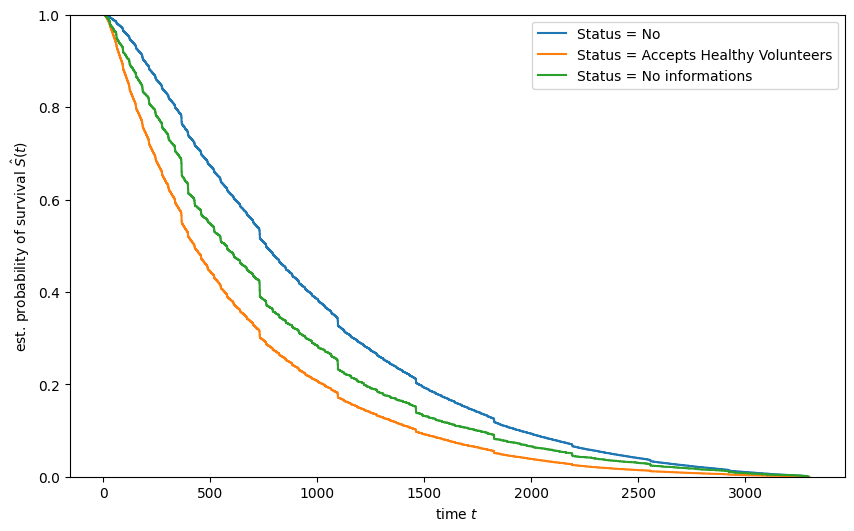

In [136]:
plot_survival_compar(df, 'HealthyVolunteers')

Il y a une différence nette entre la courbe de survie du groupe qui accepte les patients en bonne santé et celui qui ne l'accepte pas. 

In [137]:
df['CountLines'] = df['EligibilityCriteria'].str.count('\n')//10
df['CountLines'].value_counts().head(10)

CountLines
1.0    100751
0.0     44046
2.0     34981
3.0     15607
4.0      7534
5.0      4006
6.0      2243
7.0      1338
8.0       748
9.0       422
Name: count, dtype: int64

Le but du projet est aussi d'étudier si la complexité du profil de patient recherché à un impact sur la durée de l'essai clinique. On peut alors en premier lieu essayer de regarder si le nombre de lignes de la présentation des critères d'éligibilités revèle des différences significatives. On compte alors le nombre de "\n" dans la variable "EligibilityCriteria" qu'on divise par 10 pour pouvoir classer les essais cliniques de 10 en 10.

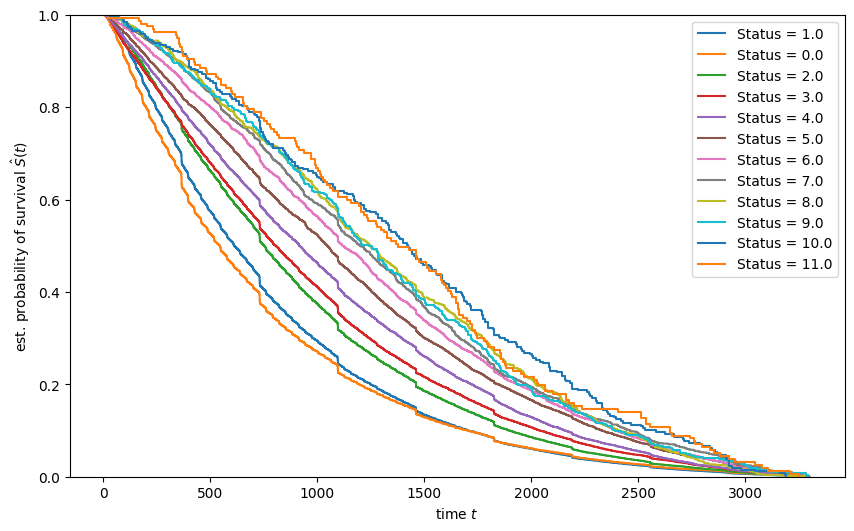

In [138]:
plot_survival_compar(df, 'CountLines', top_values= 12)

Ici, les courbes semblent être classées selon le nombre de ligne de l'essai cliniques, les différences restent cependantes légères, on étudiera de manière plus approfondies cet aspect dans la partie modélisation.